### Training data

Read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install and use [OpenSlide](https://openslide.org/), the only non-Python dependency. Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. 

This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains a few slides and tumor masks prepared in advance with ASAP. This amount of data (or less!) should be sufficient for your project. The goal is to build a thoughtful end-to-end prototype, not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442) discussed in class. If you would like more data than has been provided, you will need to use ASAP to convert it into an appropriate format. 


## Preparation

* Module import
* Google drive authentication


In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [2]:
# Enable you to read files from your google drive.
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
# Now you can write files to google drive.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# Get google drive folder list.
# Will be used when upload files to google drive
folder_list = drive.ListFile({'q': "trashed=False"}).GetList()
for folder in folder_list:
    print('folder title: %s, id: %s' % (folder['title'], folder['id']))

folder title: level3, id: 12G4m4hTpeOZdjei-zSawCZcpbpXxM_jM
folder title: COMS4995-project.ipynb, id: 1NIxEsLig_ov2Z0nAasvTNsj8tv4syRgu
folder title: neg_labels_20_4.npy, id: 10QOLjUChtSjKzFcVWAtmdTcJANtA7EtQ
folder title: neg_patches_20_4.npy, id: 1xn-ieIWPWyZbS5M6c2_ijV9eNGxHwblb
folder title: pos_labels_20_4.npy, id: 1SiPbLvLgOHwiCntRsNCEj1MkS1wvHl4d
folder title: pos_patches_20_4.npy, id: 1577FqcKlPM3EkM42BS2hDSRMLfuhbj3p
folder title: neg_labels_19_4.npy, id: 1JoYySxTqbUNtIC0bGj7ui8pYtgssl8zP
folder title: neg_patches_19_4.npy, id: 10sbfmJ91p7pzUqYKeB_4fe6tNr8DhdIF
folder title: pos_labels_19_4.npy, id: 1WKAqELV3YINZG3L180OXlCQ2eMm0OPPo
folder title: pos_patches_19_4.npy, id: 1tnRp4mNHkYUKA_2Y22BkuwZa1Bc30LEu
folder title: neg_labels_18_4.npy, id: 1HQxW28NpBiU_dln9SaaY6N-ggFK8SQTT
folder title: neg_patches_18_4.npy, id: 1pgwN30UMmJYnwr_dcs4u1wJF4nk55LgH
folder title: pos_labels_18_4.npy, id: 161S0jNQw6gzdSmP4DM0efxWdEg4799_B
folder title: pos_patches_18_4.npy, id: 1bTqVNRxMv7UYqUT

In [0]:
LEVEL2_FOLDER_ID = "16aWDTP9m_NwQaarh3WXcpl20x_CnskdK"
LEVEL4_FOLDER_ID = "11WM67AR9qWNiKs61psczNN1utEkKRJFb"
LEVEL3_FOLDER_ID = "12G4m4hTpeOZdjei-zSawCZcpbpXxM_jM"
SLIDES_DIR = '/gdrive/My Drive/Colab Notebooks/slides/'

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from random import sample
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import shutil
import json

import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

Using TensorFlow backend.


## Get all available data

This part is about general visualization of nearly all slides. If you do not want to patch from the raw data, this part is **optional**.

In [7]:
# Get files in folder
files = os.listdir('/gdrive/My Drive/Colab Notebooks/slides')
files[:2]

['tumor_091_mask.tif', 'tumor_091.tif']

In [8]:
# Get filenames for slides & masks and remove the incompleted data
slide_paths, tumor_mask_paths = [], []
for item in files:
    if item[-4:] == '.tif':
        if item[-8:-4] == 'mask':
            tumor_mask_paths.append(item)
        else:
            slide_paths.append(item)
slide_index = [item[6:9] for item in slide_paths]
slide_paths = set(slide_paths)
slide_paths.discard("tumor_038.tif")
slide_paths = sorted(list(slide_paths))
tumor_mask_paths = sorted(tumor_mask_paths)
assert len(tumor_mask_paths) == len(slide_paths)
num_tif = len(slide_paths)
print("There are %d slide-mask pairs." % num_tif)

There are 21 slide-mask pairs.


In [9]:
# Check if the slides and masks are matched up.
for slide, mask in zip(slide_paths, tumor_mask_paths):
    print(slide, mask)

tumor_001.tif tumor_001_mask.tif
tumor_002.tif tumor_002_mask.tif
tumor_005.tif tumor_005_mask.tif
tumor_012.tif tumor_012_mask.tif
tumor_016.tif tumor_016_mask.tif
tumor_019.tif tumor_019_mask.tif
tumor_023.tif tumor_023_mask.tif
tumor_031.tif tumor_031_mask.tif
tumor_035.tif tumor_035_mask.tif
tumor_057.tif tumor_057_mask.tif
tumor_059.tif tumor_059_mask.tif
tumor_064.tif tumor_064_mask.tif
tumor_075.tif tumor_075_mask.tif
tumor_078.tif tumor_078_mask.tif
tumor_081.tif tumor_081_mask.tif
tumor_084.tif tumor_084_mask.tif
tumor_091.tif tumor_091_mask.tif
tumor_094.tif tumor_094_mask.tif
tumor_096.tif tumor_096_mask.tif
tumor_101.tif tumor_101_mask.tif
tumor_110.tif tumor_110_mask.tif


In [0]:
# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x, y), level, (width, height))
    im = im.convert('RGB')  # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im


### Get info of all the slides (optional)

In [77]:
# get level info about all slides
for i, item in enumerate(slide_paths):
    real_path = SLIDES_DIR + item
    slide = open_slide(real_path)
    print("Slide no. %s with %d levels, width: %d, height: %d" % (
        slide_index[i], len(slide.level_dimensions),
        slide.level_dimensions[0][0], slide.level_dimensions[0][1]))

Slide no. 091 with 10 levels, width: 97792, height: 221184
Slide no. 001 with 10 levels, width: 97792, height: 219648
Slide no. 002 with 10 levels, width: 97792, height: 219648
Slide no. 005 with 10 levels, width: 97792, height: 215552
Slide no. 012 with 10 levels, width: 97792, height: 221184
Slide no. 016 with 10 levels, width: 97792, height: 219648
Slide no. 019 with 10 levels, width: 97792, height: 221184
Slide no. 023 with 10 levels, width: 97792, height: 221184
Slide no. 031 with 10 levels, width: 97792, height: 221184
Slide no. 035 with 10 levels, width: 97792, height: 220672
Slide no. 038 with 10 levels, width: 97280, height: 221184
Slide no. 057 with 10 levels, width: 97792, height: 220672
Slide no. 059 with 9 levels, width: 90112, height: 78848
Slide no. 064 with 9 levels, width: 94208, height: 111104
Slide no. 075 with 9 levels, width: 90112, height: 100352
Slide no. 078 with 9 levels, width: 65536, height: 86016
Slide no. 081 with 8 levels, width: 61440, height: 53760
Slide

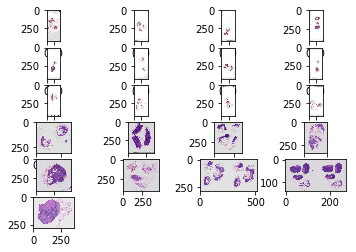

In [78]:
# show imgs at highest level to see general shape
ncol = 4
for i in range(num_tif):
    real_path = SLIDES_DIR + slide_paths[i]
    slide = open_slide(real_path)
    plt.subplot(np.ceil(num_tif / ncol), ncol, i + 1)
    level = len(slide.level_dimensions) - 1
    slide_image = read_slide(slide,
                             x=0,
                             y=0,
                             level=level,
                             width=slide.level_dimensions[level][0],
                             height=slide.level_dimensions[level][1])
    plt.imshow(slide_image)
plt.show()

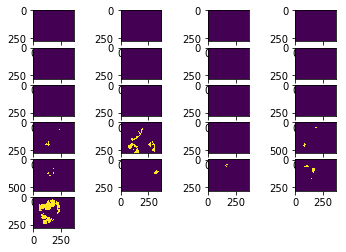

In [79]:
# show masks at highest level to see general shape
for i in range(num_tif):
    real_path = SLIDES_DIR + tumor_mask_paths[i]
    mask = open_slide(real_path)
    plt.subplot(np.ceil(num_tif / ncol), ncol, i + 1)
    level = len(mask.level_dimensions) - 1
    mask_image = read_slide(mask,
                            x=0,
                            y=0,
                            level=level,
                            width=slide.level_dimensions[level][0],
                            height=slide.level_dimensions[level][1])
    mask_image = mask_image[:, :, 1]
    plt.imshow(mask_image)
plt.show()

(2240, 2944, 3)


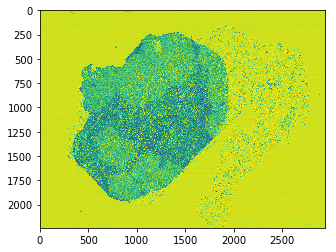

In [80]:
# experiment code block for displaying some img quickly
index = 20  # < num_tif
level = 5  # < len(mask.level_dimensions)-1
real_path = SLIDES_DIR + slide_paths[index]
mask = open_slide(real_path)
mask_image = read_slide(mask,
                        x=0,
                        y=0,
                        level=level,
                        width=slide.level_dimensions[level][0],
                        height=slide.level_dimensions[level][1])
print(mask_image.shape)
mask_image = mask_image[:, :, 0]
plt.imshow(mask_image)
plt.show()

## Patch from tif and save on VM disk and google drive
if you've already run these chunks of code, this part is **optional**, and you can read data from google drive directly.

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

In [0]:
# set threshold to be 0.1 for judging if the patch is pos or neg.
# i. e. if sum of mask is smaller than pos_label_intensity, then less than 10% of
# the label has tumor, label it as negative sample


def generate_data(slide, tumor_mask, level, stride, size,
                  neg_threshold=20, label_threshold=0.1,
                  tissue_threshold=0.15):
    # compute patch size
    pos_patch, pos_label, neg_patch, neg_label = [], [], [], []

    patch_size = (slide.level_dimensions[level][0] // stride,
                  slide.level_dimensions[level][1] // stride)
    neg_count = pos_count = 0
    # for tumor, mask[i][j]=1
    pos_label_intensity = label_threshold * size ** 2
    for col in range(patch_size[0]):
        for row in range(patch_size[1]):
            # get patch
            patch = read_slide(slide,
                               x=col * 2 ** level * stride,
                               y=row * 2 ** level * stride,
                               level=level,
                               width=size,
                               height=size)
            # calculate intensity
            tissue_pixels = find_tissue_pixels(patch)
            percent_tissue = len(tissue_pixels) / \
                (patch.shape[0] * patch.shape[1])
            if percent_tissue > tissue_threshold:
                # decide if is pos or neg using corresponding mask
                # get mask
                mask = read_slide(tumor_mask,
                                  x=col * 2 ** level * stride,
                                  y=row * 2 ** level * stride,
                                  level=level,
                                  width=size,
                                  height=size)
                mask = np.expand_dims(np.array(mask[:, :, 0]), axis=-1)
                patch = np.expand_dims(np.array(patch[:, :, 0]), axis=-1)

                # save pos sample
                if np.sum(mask) > pos_label_intensity:
                    pos_count += 1
                    pos_patch.append(patch)
                    pos_label.append(mask)

                # save neg sample
                else:
                    neg_count += 1
                    neg_patch.append(patch)
                    neg_label.append(mask)
    
    neg_count = min(neg_threshold, neg_count)
    neg_pairs = list(zip(neg_patch, neg_label))  
    neg_pairs = sample(neg_pairs, neg_threshold)
    neg_patch, neg_label = zip(*neg_pairs)
    
    print('\nNum Pos: %d, Num Neg: %d' % (pos_count, neg_count))
    return [items and np.stack(items, axis=0) for items in [pos_patch, pos_label, neg_patch, neg_label]]


In [0]:
def save(nparray, target_dir, part, index, level, folder_id):
    fname = part + "_" + str(index) + "_" + str(level) + ".npy"
    path = os.path.join(target_dir, fname)
    np.save(open(path, "wb"), nparray)
    file_metadata = {'title': fname,
                     "parents": [{"id": folder_id, "kind": "drive#childList"}]}
    folder = drive.CreateFile(file_metadata)
    folder.SetContentFile(path)
    folder.Upload()

In [0]:
level2patch = 3
path = os.path.join("/content", "level_" + str(level2patch))
if not os.path.exists(path):
    os.mkdir(path)

In [17]:
stride = 256
size = 256
folder_id = LEVEL3_FOLDER_ID

start = 0  # if the code break down, you can change this para to the break point to continue
for i in tqdm(range(start, num_tif)):
    slide_path = SLIDES_DIR + slide_paths[i]
    slide = open_slide(slide_path)
    tumor_mask_path = SLIDES_DIR + tumor_mask_paths[i]
    tumor_mask = open_slide(tumor_mask_path)
    pos_patches, pos_labels, neg_patches, neg_labels = generate_data(
        slide, tumor_mask, level2patch, stride, size)
    if not isinstance(pos_patches, list):
        save(pos_patches, path, "pos_patches", i, level2patch, folder_id)
        save(pos_labels, path, "pos_labels", i, level2patch, folder_id)
        save(neg_patches, path, "neg_patches", i, level2patch, folder_id)
        save(neg_labels, path, "neg_labels", i, level2patch, folder_id)
        print("\ntif %d saved" % i)

  0%|          | 0/21 [00:00<?, ?it/s]


Num Pos: 7, Num Neg: 20


  5%|▍         | 1/21 [00:42<14:08, 42.41s/it]


tif 0 saved

Num Pos: 1, Num Neg: 20


 10%|▉         | 2/21 [01:17<12:45, 40.31s/it]


tif 1 saved

Num Pos: 2, Num Neg: 20


 14%|█▍        | 3/21 [01:52<11:35, 38.66s/it]


tif 2 saved

Num Pos: 1, Num Neg: 20


 19%|█▉        | 4/21 [02:29<10:48, 38.16s/it]


tif 3 saved

Num Pos: 55, Num Neg: 20


 24%|██▍       | 5/21 [03:06<10:03, 37.69s/it]


tif 4 saved

Num Pos: 4, Num Neg: 20


 29%|██▊       | 6/21 [03:41<09:13, 36.87s/it]


tif 5 saved

Num Pos: 2, Num Neg: 20


 33%|███▎      | 7/21 [04:17<08:33, 36.65s/it]


tif 6 saved

Num Pos: 66, Num Neg: 20


 38%|███▊      | 8/21 [04:53<07:54, 36.47s/it]


tif 7 saved


 43%|████▎     | 9/21 [05:24<06:58, 34.89s/it]


Num Pos: 0, Num Neg: 20


 48%|████▊     | 10/21 [05:55<06:10, 33.67s/it]


Num Pos: 0, Num Neg: 20


 52%|█████▏    | 11/21 [06:27<05:31, 33.13s/it]


Num Pos: 0, Num Neg: 20

Num Pos: 55, Num Neg: 20


 57%|█████▋    | 12/21 [07:03<05:05, 33.99s/it]


tif 11 saved

Num Pos: 26, Num Neg: 20


 62%|██████▏   | 13/21 [07:20<03:51, 28.88s/it]


tif 12 saved

Num Pos: 342, Num Neg: 20


 67%|██████▋   | 14/21 [07:52<03:30, 30.05s/it]


tif 13 saved

Num Pos: 1, Num Neg: 20


 71%|███████▏  | 15/21 [08:14<02:44, 27.39s/it]


tif 14 saved

Num Pos: 13, Num Neg: 20


 76%|███████▌  | 16/21 [08:29<01:59, 23.86s/it]


tif 15 saved

Num Pos: 21, Num Neg: 20


 81%|████████  | 17/21 [08:41<01:21, 20.36s/it]


tif 16 saved

Num Pos: 22, Num Neg: 20


 86%|████████▌ | 18/21 [09:09<01:07, 22.55s/it]


tif 17 saved

Num Pos: 17, Num Neg: 20


 90%|█████████ | 19/21 [09:31<00:44, 22.40s/it]


tif 18 saved

Num Pos: 72, Num Neg: 20


 95%|█████████▌| 20/21 [09:56<00:23, 23.24s/it]


tif 19 saved

Num Pos: 318, Num Neg: 20


100%|██████████| 21/21 [10:19<00:00, 23.06s/it]


tif 20 saved


## Read data from google drive

In [0]:
PREPROCESSED_DIR = "/gdrive/My Drive/Colab Notebooks/preprocessed_data/level"
level2read = 3
data_dir = PREPROCESSED_DIR + str(level2read)

In [19]:
data_fnames = os.listdir(data_dir)
data_fnames[:6]

['neg_labels_0_3.npy',
 'neg_patches_0_3.npy',
 'pos_labels_0_3.npy',
 'pos_patches_0_3.npy',
 'neg_labels_1_3.npy',
 'neg_patches_1_3.npy']

In [20]:
pos_patches, pos_labels, neg_patches, neg_labels = [], [], [], []
for fname in tqdm(sorted(data_fnames)):
    array = np.load(open(os.path.join(data_dir, fname), 'rb'))
    if "pos_patches" in fname:
        pos_patches.append(array)
    elif "pos_labels" in fname:
        pos_labels.append(array)
    elif "neg_patches" in fname:
        neg_patches.append(array)
    elif "neg_labels" in fname:
        neg_labels.append(array)
    else:
        raise ExceptionError

x_pos = np.concatenate(pos_patches, axis=0)
y_pos = np.concatenate(pos_labels, axis=0)
x_neg = np.concatenate(neg_patches, axis=0)
y_neg = np.concatenate(neg_labels, axis=0)

assert x_pos.shape[0] == y_pos.shape[0]
assert x_neg.shape[0] == y_neg.shape[0]

x_pos.shape, y_pos.shape, x_neg.shape, y_neg.shape

100%|██████████| 72/72 [00:21<00:00,  3.11it/s]


((1025, 256, 256, 1),
 (1025, 256, 256, 1),
 (360, 256, 256, 1),
 (360, 256, 256, 1))

In [0]:
# compare the img & mask & prediction.
# or display img only.
def show_image(img, mask=None, pred=None, nrow=5, offset=0):
    plt.figure(figsize=(7, 7))
    ncol = 1 + (mask is not None) + (pred is not None)
    for i in range(nrow):
        plt.subplot(nrow, ncol, ncol * i + 1)
        plt.axis("off")
        plt.imshow(np.squeeze(img[i + offset]), cmap=plt.cm.binary)
        
        if mask is not None:
            plt.subplot(nrow, ncol, ncol * i + 2)
            plt.axis("off")
            plt.imshow(np.squeeze(mask[i + offset]), cmap=plt.cm.binary)  
            
        if pred is not None:
            plt.subplot(nrow, ncol, ncol * i + 3)
            plt.axis("off")
            plt.imshow(np.squeeze(pred[i + offset]), cmap=plt.cm.binary)   

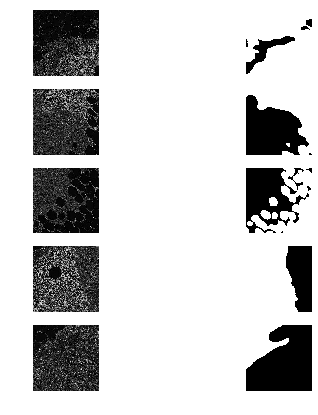

In [23]:
show_image(x_pos, y_pos, nrow=5, offset=40)

## Train the U-net model

In [46]:
with_neg = False

if with_neg:   
    x = np.concatenate([x_pos, x_neg], axis=0) / 255.0
    y = np.concatenate([y_pos, y_neg], axis=0)
else:
    x = x_pos / 255.0
    y = y_pos
    
x.shape, y.shape

((1025, 256, 256, 1), (1025, 256, 256, 1))

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((820, 256, 256, 1),
 (205, 256, 256, 1),
 (820, 256, 256, 1),
 (205, 256, 256, 1))

In [49]:
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model
  
model = unet(input_size=(256, 256, 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [50]:
model.fit(x_train, y_train, 16, 5, validation_data=(x_test, y_test))

Train on 820 samples, validate on 205 samples
Epoch 1/5
820/820 [==============================] - 63s 77ms/step - loss: 0.6269 - acc: 0.6435 - val_loss: 0.6168 - val_acc: 0.6569
Epoch 2/5
820/820 [==============================] - 58s 71ms/step - loss: 0.4791 - acc: 0.7925 - val_loss: 0.3444 - val_acc: 0.8721
Epoch 3/5
820/820 [==============================] - 59s 72ms/step - loss: 0.4202 - acc: 0.8456 - val_loss: 0.4443 - val_acc: 0.8910
Epoch 4/5
112/820 [===>..........................] - ETA: 46s - loss: 0.3722 - acc: 0.8712

KeyboardInterrupt: ignored

In [0]:
def predict(model, x_test):
    pred = model.predict(x_test)
    pred = np.where(pred > 0.5, 1, 0)
    return pred

In [0]:
pred = predict(model, x_test)

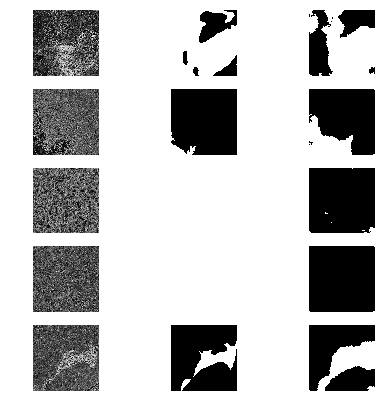

In [59]:
show_image(x_test, y_test, pred, offset=11)

In [0]:
neg_pred = predict(model, x_neg)

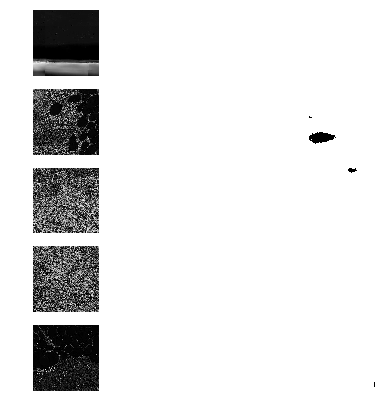

In [64]:
show_image(x_neg, y_neg, neg_pred, offset=25)

In [66]:
neg_pred[0]

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [1]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]])